# image alignment tests


In [1]:
import cv2
import os
import numpy as np
import math
import matplotlib.pyplot as plt

from skimage.filters import threshold_multiotsu
from skimage.segmentation import slic, mark_boundaries
from skimage import color
import pandas as pd
import seaborn as sns
import multiprocessing
import time

import napari
from napari import settings

from align import *


In [2]:
#folder='E:/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/SEM Image/'
#folder='E:/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/EDS/'

folder='Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/'
z_scale=192
mask_size=0.7
limit=[1,79]#[18,80]
eds_x_offset = 404.8#+22
eds_y_offset = 50.8
#eds_each_nth_slice = 10
#expected_img_count = 63
relevant_elements = ['Ca', 'Si', 'C', 'O', 'Pt']
colormaps = ["red", "green", "blue", "yellow", "magenta"]
# superpixel settings
n_segments = 200
compactness = 0.3


"""
folder='Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/SEM Image/' 
mask_size=0.6
z_scale=19.2
limit=[56,600]
"""
#folder='E:/SEM Image/'
#folder='F:/2020_11_19 C3S 28d+EDX/EDS Export/'
sem_folder='F:/2020_11_19 C3S 28d+EDX/Images/SEM Image/'
#folder='D:/Avizo-Projekte/2022_01_30 CEM I 28d BIB 01-26/Images/SEM Image/'

In [3]:
folder, eds_elements = check_folder_structure(folder)

identified 14 elements


In [4]:
sem_translation, error_list, filled_canvas, loaded_images, scaling = process_translation_of_folder(folder=folder, multicore=False, do_nlm=False, mask_size=mask_size, eq_hist=True, crop_thresh=0, limit=limit )#, limit=[5,600]

loading 78 images...
tag[282] ((96000, 1000),)
tag[283] ((96000, 1000),)
eds ['0,0269430014623621', '/']
  Image is an EDS image by Aztec
  26.943 x 26.943 nm/px

Found existing translation csv, loading...
Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/Images\\translations.csv contains 78 lines, while 77 lines were expected
processing 78 images...
processing image stack singlethreaded:
 processing Elektronenbild 4.tif (1 / 78):
 processing Elektronenbild 5.tif (2 / 78):
 processing Elektronenbild 6.tif (3 / 78):
 processing Elektronenbild 7.tif (4 / 78):
 processing Elektronenbild 8.tif (5 / 78):
 processing Elektronenbild 9.tif (6 / 78):
 processing Elektronenbild 10.tif (7 / 78):
 processing Elektronenbild 11.tif (8 / 78):
 processing Elektronenbild 12.tif (9 / 78):
 processing Elektronenbild 13.tif (10 / 78):
 processing Elektronenbild 14.tif (11 / 78):
 processing Elektronenbild 15.tif (12 / 78):
 processing Elektronenbild 16.tif (13 / 78):

In [5]:
im_cnt = len(loaded_images)
scale=(z_scale, scaling['y'], scaling['x'])

# add a shape and mark the top line of the cube

### correction of the y and x-translation

In [6]:
translation   = sem_translation.copy()
base_fn = folder + os.sep + 'translations_{}.csv'
#print(translation)
translation_csv_y    = base_fn.format('fixed_y')
translation_csv_xy   = base_fn.format('fixed_xy')
translation_manual_x = base_fn.format('manual_x')
translation_manual_y = base_fn.format('manual_y')
crop_manual          = base_fn.format('crop')


fixed_translation = load_translation_csv( translation_csv_xy, im_cnt )
final_images = None
a_list = []            
b_list = []

if len(fixed_translation) < im_cnt-1:
    if len(fixed_translation) > 0:
        print(len(fixed_translation), im_cnt)
    #avoid the execution of following jupyter cells
    napari.settings.get_settings().application.ipy_interactive  = False
    viewer = napari.view_image(filled_canvas, name='image stack [Y]', scale=scale)
    viewer.scale_bar.visible = True
    #viewer.add_shapes(name="select y correction line",shape_type='path', edge_width=1, edge_color='coral', face_color='royalblue', opacity=0.3)
    viewer.dims.order = (2,0,1)
    # with napari.gui_qt():
    #     viewer = napari.view_image(filled_canvas, name='select y correction line', scale=scale )
    @viewer.bind_key('y')
    def correct_y(viewer):
        global translation
        global translation_csv_y
        global translation_csv_xy
        global translation_manual_y
        print(viewer.layers['Shapes'].data[0])

        correction_dict = {}
        for point in viewer.layers['Shapes'].data[0]:
            correction_dict[math.floor(point[0])] = point[1] # position of relevant coordinate seems to change depending on viewer.dims.order setting
        print('y', correction_dict)

        y_correction_list = get_axis_correction_list( correction_dict, im_cnt )        
        np.savetxt(translation_manual_y, np.array(y_correction_list), delimiter=",")

        for i, y in enumerate(y_correction_list):
            #print(i, y)
            #print(i, y, translation[i-1][1], translation[i-1][1] - y)
            if i>0: 
                translation[i-1][1] -= y
                #translation[i-1].append( y )
        #print(translation)
        save_translation_csv( translation, translation_csv_y )
        
        corrected_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(corrected_images, name='image stack [X]', scale=scale)
        viewer.dims.order = (1,2,0)
        viewer.layers.remove('Shapes')
        viewer.layers.remove('image stack [Y]')

        #viewer.add_shapes(name="select x correction line", shape_type='path', edge_width=1, edge_color='red', face_color='green', opacity=0.3)

    @viewer.bind_key('x')
    def correct_x(viewer):
        global translation
        global translation_csv_xy
        global translation_manual_x
        global final_images
        print(viewer.layers['Shapes'].data[0])

        correction_dict = {}
        for point in viewer.layers['Shapes'].data[0]:
            correction_dict[math.floor(point[0])] = point[2] # position of relevant coordinate seems to change depending on viewer.dims.order setting
        print('x', correction_dict)

        x_correction_list = get_axis_correction_list( correction_dict, im_cnt )
        np.savetxt(translation_manual_x, np.array(x_correction_list), delimiter=",")

        for i, x in enumerate(x_correction_list):
            #print(i, x)
            #print(i, x, translation[i-1][2], translation[i-1][2] + x)
            if i>0: 
                translation[i-1][2] += x
        
        #print(translation)
        final_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(final_images, name='[C]rop to Rectangle', scale=scale)
        viewer.dims.order = (0,1,2)
        viewer.layers.remove('image stack [X]')
        viewer.layers.remove('Shapes')
        #viewer.dims.ndisplay = 3

    @viewer.bind_key('c')
    def crop(viewer):
        global final_images
        global a_list           
        global b_list
        global crop_manual
        
        #print(viewer.layers['Shapes'].data)
        
        if len(viewer.layers['Shapes'].data[0]) == 4:
            for point in viewer.layers[1].data[0]:
                a = round(point[1])
                b = round(point[2])
                if not a in a_list: a_list.append(a)
                if not b in b_list: b_list.append(b)
        else:
            print('found less or more points than expected ({})'.format(len(viewer.layers[1].data[0])))

        a_list.sort()
        b_list.sort()
        crop_arr = np.array([a_list[0], a_list[1], b_list[0], b_list[1]])
        final_images = final_images[ :, crop_arr[0]:crop_arr[1], crop_arr[2]:crop_arr[3] ]
        np.savetxt(crop_manual, crop_arr, delimiter=",")
        
        #corrected_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(final_images, name='image stack Final, press [S] to save', scale=scale)
        viewer.dims.order = (0,1,2)
        viewer.layers.remove('Shapes')
        viewer.layers.remove('[C]rop to Rectangle')
        viewer.dims.ndisplay = 3

    @viewer.bind_key('s')
    def correct_x(viewer):
        #global translation
        save_translation_csv( translation, translation_csv_xy )

        print('closing')
        viewer.close()
    
    napari.run()
    napari.settings.get_settings().application.ipy_interactive  = True
else:
    translation = fixed_translation
    crop_arr = np.loadtxt( crop_manual, dtype=int )

#print(translation)

Found existing translation csv, loading...
Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/Images\\translations_fixed_xy.csv contains 78 lines, while 77 lines were expected


## load EDS images

In [7]:
def process_element(eds_elements, selected_element, se_translation,  eds_x_offset, eds_y_offset, limit=[]):
    if selected_element in eds_elements.keys():
        print('-'*20)
        print('selected element is {}'.format(selected_element))
    else:
        print('ERROR: element {} not found in the dataset'.format(selected_element))

    

    folder = eds_elements[selected_element]
    images, loaded_images = load_image_set(folder, limit)
    
    #corrected_images = loaded_images
    if len(images) > 1:
        shapes = []
        shape_counts = []
        #image_numbering = []
        for i, image in enumerate(loaded_images):
            shape = image.shape
            if not shape in shapes:
                shapes.append(shape)
                shape_counts.append(0)
            shape_counts[-1] +=1

        if len(shapes) > 1:
            print( ' Found multiple shapes!' )
            for i, shape in enumerate(shapes):
                print('  found {} images with this shape:'.format(shape_counts[i]), shape)

        # TODO select the indended stack?
        ignore_first_n_images = 18 #shape_counts[0]-1 if len(shapes) > 1 else 0
        ignore_last_n_images = shape_counts[-2] if len(shapes) == 3 else 0
        x_offset = 0
        y_offset = 0

        # correcting position of the eds image relative to the SE images
        if ignore_first_n_images > 0:
            t_x, t_y  = get_full_img_translation(se_translation, ignore_first_n_images)
            print('  - eds x translation: {} - {} + {} '.format(eds_x_offset, t_x[0], t_x[1]))
            print('  - eds y translation: {} - {} + {} '.format(eds_y_offset, t_y[0], t_y[1] ))
            x_offset = eds_x_offset - t_x[0] + t_x[1]
            y_offset = eds_y_offset - t_y[0] + t_y[1]
            print('  - final translation {} and {}'.format( x_offset, y_offset ) )
            print( - t_y[0] + t_y[1] )

        if ignore_last_n_images == 0:
            img_stack = loaded_images[ignore_first_n_images:]
            # select images to be displayed
            selected_translation = se_translation[ignore_first_n_images-1 :]
            #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1]+eds_x_offset, selected_translation[0][2]+eds_y_offset]
        else:
            loaded_images[ignore_first_n_images : ignore_last_n_images]
            # select images to be displayed
            selected_translation = se_translation[ignore_first_n_images-1 : ignore_last_n_images]
            #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1]+eds_x_offset, selected_translation[0][2]+eds_y_offset]

        print(selected_translation[0])
        #selected_translation[0] = [selected_translation[0][0], -50, -10]#y_offset]
        #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1] + y_offset, selected_translation[0][2] + x_offset]
        #print(selected_translation[0])

        # process eds images to reduce noise
        print(' denoising images and enhance contrast')
        for i, img in enumerate(img_stack):
            img_stack[i] = preprocess_eds_image(img)

        #corrected_images = create_3D_stack(selected_translation, img_stack, do_nlm=False, first_x_offset =49, first_y_offset =471 )
        corrected_images = create_3D_stack(selected_translation, img_stack, do_nlm=False, first_x_offset=x_offset, first_y_offset=y_offset )#52 )#x_offset = 471  y_offset should be 49-52??

        cs = corrected_images.shape
        ecs = (ignore_first_n_images + cs[0] + ignore_last_n_images, cs[1], cs[2])

        if len(shapes) > 1:
            if ignore_first_n_images > 1:
                temp = np.zeros(ecs)

                if ignore_last_n_images == 0:
                    temp[ignore_first_n_images:,:,:] = corrected_images
                else:
                    temp[ignore_first_n_images:-ignore_last_n_images,:,:] = corrected_images

                corrected_images = temp

    return corrected_images

visualize the raw data after minor processing

In [8]:
napari.settings.get_settings().application.ipy_interactive  = False
translation          = load_translation_csv( translation_csv_xy, im_cnt )
corrected_sem_images = create_3D_stack(translation, loaded_images, False)

if len(eds_elements) > 0:
    scale=(z_scale, scaling['y'], scaling['x'])
    elements_raw = {}
    for element in eds_elements.keys():
        if element in relevant_elements:
            stack = process_element(eds_elements, element, translation, eds_x_offset, eds_y_offset, limit=limit)
            if len(stack) != len(loaded_images):
                print('Dataset for {} is incomplete ({} != {})'.format(element, len(stack), len(loaded_images)))
            else:
                print(crop_arr[0],crop_arr[1], crop_arr[2],crop_arr[3])
                elements_raw[element] = stack[ :, crop_arr[0]:crop_arr[1], crop_arr[2]:crop_arr[3] ].astype(np.uint8)
        else:
            print('-'*20)
            print('ignoring {}'.format(element))

    # show image stacks
    print('translate and display image stack using the following voxel dimensions: x={:.2f}, y={:.2f}, z={:.2f} {}'.format(scale[2], scale[1], scale[0], scaling['unit']))
    #scale=(z_scale*eds_each_nth_slice, x_scale/math.cos(38), x_scale)
    #with napari.gui_qt():
    viewer = napari.view_image(corrected_sem_images[ :, crop_arr[0]:crop_arr[1], crop_arr[2]:crop_arr[3] ], name='SEM images', scale=scale, title="RAW EDX data")#

    for i, selected_element in enumerate(relevant_elements):
        #new_layer = viewer.add_image(image_stacks[selected_element], name='EDS results for {}'.format(selected_element), scale=scale, colormap=colormaps[i], opacity=1, blending="additive", rendering="iso")
        new_layer = viewer.add_image(elements_raw[selected_element], name='EDX results for {}'.format(selected_element), scale=scale, colormap=colormaps[i], opacity=0.5, blending="additive", rendering="mip")
    viewer.scale_bar.visible = True
    
    napari.run()
else:
    print('no elements found')

Found existing translation csv, loading...
Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/Images\\translations_fixed_xy.csv contains 78 lines, while 77 lines were expected
Create 3D image stack with corrected image translation
  - allocating 3D image space..
  - translating and denoising images..
image count  (78) equals translations (78 and 78)!
--------------------
ignoring Ag
--------------------
ignoring Al
--------------------
ignoring Ar
--------------------
selected element is C
loading 78 images...
 Found multiple shapes!
  found 16 images with this shape: (654, 565)
  found 62 images with this shape: (624, 515)
  - eds x translation: 404.8 - -152.8039591100711 + -78.51923994080185 
  - eds y translation: 50.8 - -24.724548038689306 + -23.349314648485997 
  - final translation 479.0847191692693 and 52.1752333902033
1.3752333902033094
['Elektronenbild 21.tif', 1.375233390203308, 3.932203976703807]
 denoising images and enhance contrast
Cr

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [9]:

global elements_SLIC
global elements_mean_SLIC
for element in relevant_elements:
    elements_SLIC[element]      = []
    elements_mean_SLIC[element] = []
    
    for i, image in enumerate( elements_raw[element] ):
        elements_SLIC[element].append([])
        elements_mean_SLIC[element].append([])


coreCount = multiprocessing.cpu_count()
processCount = (coreCount - 1) if coreCount > 1 else 1

#enhance contrast and crop images SLIC-segments
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))

#create SLIC-segments
for element in relevant_elements:

    #for i, image in enumerate( elements_raw[element] ):
    #    print( " processing {} ({} / {})".format(element, i+1, len(elements_raw[element])) )
    #    SLIC_result_processing(SLIC_image(image, element, i))

    pool = multiprocessing.Pool(processCount)
    image_cnt = len(elements_raw[element])
    print( " processing {} ({} slices)".format(element, image_cnt) )
    for i in range(image_cnt):
        # enhance contrast
        img = elements_raw[element][i,...]# clahe.apply( image )
        x = pool.apply_async(get_SLIC_segments, args=(img, element, i, n_segments, compactness), callback = SLIC_segment_processing)
        #x.get()
    pool.close()
    pool.join()
"""
napari.settings.get_settings().application.ipy_interactive  = True

viewer    = napari.view_image(elements_SLIC[element][0])
viewer.scale_bar.visible = True

napari.run()"""

 processing Ca (78 slices)
 processing Si (78 slices)
 processing C (78 slices)
 processing O (78 slices)
 processing Pt (78 slices)


'\nnapari.settings.get_settings().application.ipy_interactive  = True\n\nviewer    = napari.view_image(elements_SLIC[element][0])\nviewer.scale_bar.visible = True\n\nnapari.run()'

In [10]:

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
threshold = 1#100
benchmark = True

#combine SLIC-segments
for i in range( len(elements_raw[relevant_elements[0]]) ):
    for j, element in enumerate( relevant_elements[1:] ):
        elements_SLIC[relevant_elements[0]][i] = elements_SLIC[relevant_elements[0]][i] * 1000 + elements_SLIC[element][i]

#get SLIC mean
for element in relevant_elements:
    start = time.time()
    pool = multiprocessing.Pool(processCount)
    image_cnt = len(elements_raw[element])
    print( " processing {} ({} slices)".format(element, image_cnt) )
    #print(elements_raw[element].shape)
    #for i, image in enumerate( elements_raw[element] ):
    for i in range(image_cnt):
            
        # enhance contrast
        img_clahe = elements_raw[element][i,...]# clahe.apply( image )
        #print(img_clahe.shape)
        #print( elements_SLIC[relevant_elements[0]][0].shape,  len(elements_SLIC[relevant_elements[0]]))
        if benchmark:
            get_SLIC_mean_Image(img_clahe, elements_SLIC[relevant_elements[0]][i], element, i, threshold)
            end = time.time()
            print('  first slice took {:.2f} s'.format( end - start ) )
            print('  will take propably {:.2f} s'.format( (end - start)*image_cnt*len(relevant_elements)) )
            benchmark = False

        x = pool.apply_async(get_SLIC_mean_Image, args=(img_clahe, elements_SLIC[relevant_elements[0]][i], element, i, threshold), callback = SLIC_mean_processing)
        #x.get()
    pool.close()
    pool.join()
    end = time.time()
    print('  took {:.2f} s'.format( end - start ) )
"""
    
napari.settings.get_settings().application.ipy_interactive  = True
viewer    = napari.view_image(np.array(elements_mean_SLIC[relevant_elements[0]]))
viewer.scale_bar.visible = True

napari.run()"""

 processing Ca (78 slices)
  first slice took 0.30 s
  will take propably 118.63 s
  took 22.86 s
 processing Si (78 slices)
  took 24.70 s
 processing C (78 slices)
  took 22.06 s
 processing O (78 slices)
  took 22.97 s
 processing Pt (78 slices)
  took 23.34 s


'\n    \nnapari.settings.get_settings().application.ipy_interactive  = True\nviewer    = napari.view_image(np.array(elements_mean_SLIC[relevant_elements[0]]))\nviewer.scale_bar.visible = True\n\nnapari.run()'

In [11]:


"""
def SLIC_selected_image(element, slice):
    folder = eds_elements[element]
    _, loaded_images = load_image_set(folder, limit)

    img_raw = loaded_images[slice]

    mean_slic = SLIC_image(img)

    return img_raw, mean_slic

img_raw1, mean_slic1 = SLIC_selected_image(selected_element1, selected_slice)
img_raw2, mean_slic2 = SLIC_selected_image(selected_element2, selected_slice)
img_raw3, mean_slic3 = SLIC_selected_image(selected_element3, selected_slice)

data = pd.DataFrame({selected_element1: np.reshape(mean_slic1,  -1, order='F'),
                     selected_element2: np.reshape(mean_slic2,  -1, order='F'),
                     selected_element3: np.reshape(mean_slic3,  -1, order='F')} )

sns.jointplot(x = selected_element1, y = selected_element2, data = data)
plt.show()
sns.jointplot(x = selected_element1, y = selected_element3, data = data)
plt.show()
sns.jointplot(x = selected_element2, y = selected_element3, data = data)
plt.show()



elements_SLIC      = {}
elements_mean_SLIC = {}
for element in elements:
    elements_SLIC[element]      = []
    elements_mean_SLIC[element] = []
    for image in elements_raw[element]:
        segments_slic, mean_slic = SLIC_image(image)
        elements_SLIC[element].append(segments_slic)
        elements_mean_SLIC[element].append(mean_slic)
        


fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(25, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_raw, interpolation=None);
ax[0].set_title('{}'.format(images[selected_slice]))

ax[1].imshow(
cv2.medianBlur(cleanedImage, ksize=5), interpolation=None);
ax[1].set_title('filtered1')

ax[2].imshow(mean_slic1, interpolation=None);
ax[2].set_title('SLIC {}'.format(selected_element1))

ax[3].imshow(mean_slic2, interpolation=None);
ax[3].set_title('SLIC {}'.format(selected_element2))

ax[4].imshow(mean_slic3, interpolation=None);
ax[4].set_title('SLIC {}'.format(selected_element3))
for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()"""

#plt.scatter(np.reshape(mean_slic1,  -1, order='F'), np.reshape(mean_slic2,  -1, order='F'))
#plt.hist2d(np.reshape(mean_slic1,  -1, order='F'), np.reshape(mean_slic2,  -1, order='F'), bins=32)

#plt.hist(np.reshape(mean_slic1,  -1, order='F'), bins=64, range=(0,1))
#plt.hist(np.reshape(mean_slic2,  -1, order='F'), bins=64, range=(0,1))


"\ndef SLIC_selected_image(element, slice):\n    folder = eds_elements[element]\n    _, loaded_images = load_image_set(folder, limit)\n\n    img_raw = loaded_images[slice]\n\n    mean_slic = SLIC_image(img)\n\n    return img_raw, mean_slic\n\nimg_raw1, mean_slic1 = SLIC_selected_image(selected_element1, selected_slice)\nimg_raw2, mean_slic2 = SLIC_selected_image(selected_element2, selected_slice)\nimg_raw3, mean_slic3 = SLIC_selected_image(selected_element3, selected_slice)\n\ndata = pd.DataFrame({selected_element1: np.reshape(mean_slic1,  -1, order='F'),\n                     selected_element2: np.reshape(mean_slic2,  -1, order='F'),\n                     selected_element3: np.reshape(mean_slic3,  -1, order='F')} )\n\nsns.jointplot(x = selected_element1, y = selected_element2, data = data)\nplt.show()\nsns.jointplot(x = selected_element1, y = selected_element3, data = data)\nplt.show()\nsns.jointplot(x = selected_element2, y = selected_element3, data = data)\nplt.show()\n\n\n\nelement

In [18]:

napari.settings.get_settings().application.ipy_interactive = False

for i, selected_element in enumerate( relevant_elements ):
    volume  =  np.array(elements_mean_SLIC[selected_element])#create_3D_stack(translation, elements_mean_SLIC[element], do_nlm=False)
    if i == 0:
        viewer    = napari.view_image(volume, name='EDX Superpixel ({})'.format(selected_element), scale=scale, opacity=0.5, blending="additive", rendering="mip", colormap=colormaps[i], title="superpixel segmentation")
    else:
        new_layer =  viewer.add_image(volume, name='EDX Superpixel ({})'.format(selected_element), scale=scale, opacity=0.5, blending="additive", rendering="mip", colormap=colormaps[i])
for i, selected_element in enumerate(relevant_elements):
    new_layer = viewer.add_image(elements_raw[selected_element], name='EDX raw ({})'.format(selected_element), scale=scale, colormap=colormaps[i], opacity=0.5, blending="additive", rendering="mip")
viewer.scale_bar.visible = True


napari.run()

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Trying to find / visualize concentration clusters

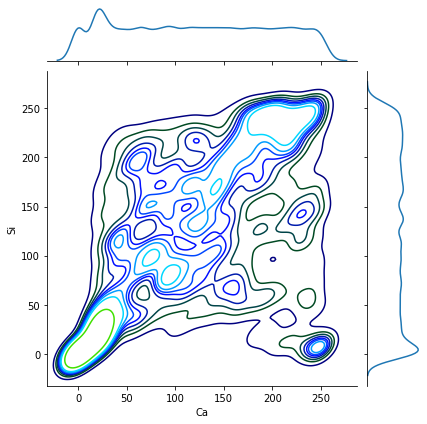

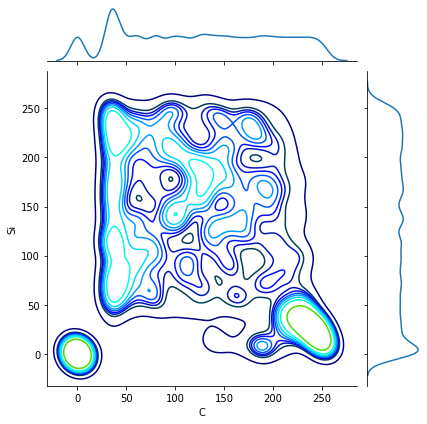

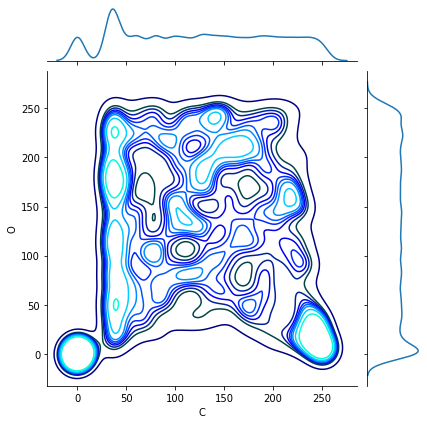

In [20]:
slice_nr = 50
data = pd.DataFrame({relevant_elements[0]: np.concatenate(elements_mean_SLIC[relevant_elements[0]][slice_nr]).ravel() ,
                     relevant_elements[1]: np.concatenate(elements_mean_SLIC[relevant_elements[1]][slice_nr]).ravel() ,
                     relevant_elements[2]: np.concatenate(elements_mean_SLIC[relevant_elements[2]][slice_nr]).ravel() ,
                     relevant_elements[3]: np.concatenate(elements_mean_SLIC[relevant_elements[3]][slice_nr]).ravel() ,
                     relevant_elements[4]: np.concatenate(elements_mean_SLIC[relevant_elements[4]][slice_nr]).ravel()  })
                     
plt = sns.jointplot(x = relevant_elements[0], y = relevant_elements[1], data = data,kind="kde", cmap='gist_ncar')#, kind="kde"
                     
plt = sns.jointplot(x = relevant_elements[2], y = relevant_elements[1], data = data,kind="kde", cmap='gist_ncar')#, kind="kde"

plt = sns.jointplot(x = relevant_elements[2], y = relevant_elements[3], data = data,kind="kde", cmap='gist_ncar')#, kind="kde"

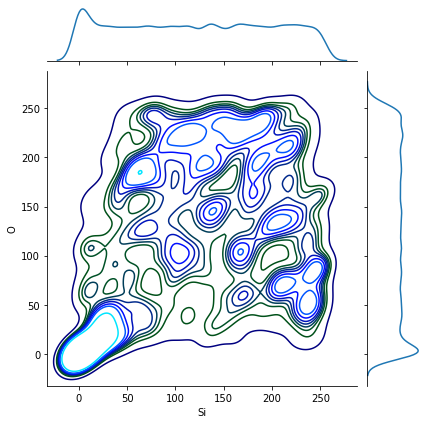

In [21]:

plt = sns.jointplot(x = relevant_elements[1], y = relevant_elements[3], data = data,kind="kde", cmap='gist_ncar')#, kind="kde"

           Ca  Si    C
0           0   0    0
1           0   0    0
2           0   0    0
3           0   0    0
4           0   0    0
...       ...  ..  ...
10745587  192  32  119
10745588  192  32  119
10745589  192  32  119
10745590  192  32  119
10745591  192  32  119

[10745592 rows x 3 columns]
saving to Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/Images\SLIC.csv


(1.0, 255.0)

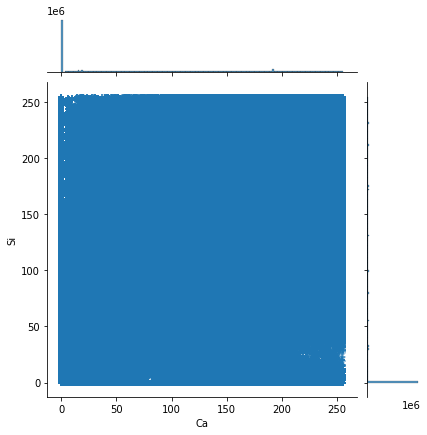

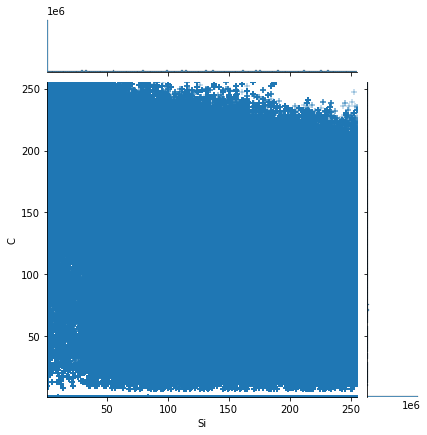

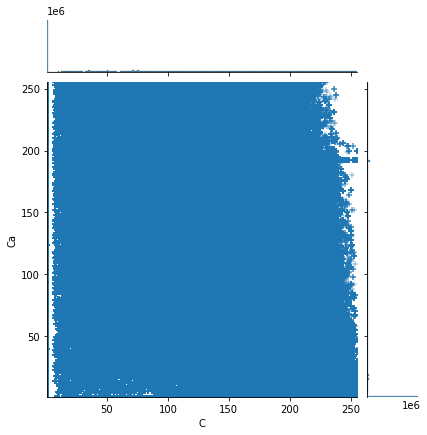

In [14]:
"""slice_nr = 50
data = pd.DataFrame({elements[0]: np.concatenate(elements_mean_SLIC[elements[0]][slice_nr]).ravel() ,
                     elements[1]: np.concatenate(elements_mean_SLIC[elements[1]][slice_nr]).ravel() ,
                     elements[2]: np.concatenate(elements_mean_SLIC[elements[2]][slice_nr]).ravel()  })"""

                     
data = pd.DataFrame({relevant_elements[0]: np.concatenate(elements_mean_SLIC[relevant_elements[0]]).ravel() ,
                     relevant_elements[1]: np.concatenate(elements_mean_SLIC[relevant_elements[1]]).ravel() ,
                     relevant_elements[2]: np.concatenate(elements_mean_SLIC[relevant_elements[2]]).ravel()  })
print( data)
print('saving to', folder+'SLIC.csv')
data.to_csv(folder+'SLIC.csv')

#plt = sns.pairplot(data = data,palette='magma')#, kind="kde"
plt = sns.jointplot(x = relevant_elements[0], y = relevant_elements[1], data = data,marker="+")#, kind="kde"
#plt.ax_marg_x.set_xlim(threshold, 255)
#plt.ax_marg_y.set_ylim(threshold, 255)

plt = sns.jointplot(x = relevant_elements[1], y = relevant_elements[2], data = data,marker="+")
plt.ax_marg_x.set_xlim(threshold, 255)
plt.ax_marg_y.set_ylim(threshold, 255)

plt = sns.jointplot(x = relevant_elements[2], y = relevant_elements[0], data = data,marker="+")
plt.ax_marg_x.set_xlim(threshold, 255)
plt.ax_marg_y.set_ylim(threshold, 255)


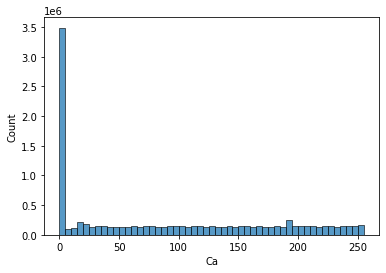

In [15]:

plt = sns.histplot(data=data[relevant_elements[0]], binwidth=5)# .jointplot(x = relevant_elements[0], y = relevant_elements[1], data = data,kind="kde",cmap='gist_ncar')#, kind="kde"

In [16]:
#todo

# preprocess the raw eds images - denoising, contrast enhancing and segmentation
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
def preprocess_sem_image(img):
    tmp = clahe.apply(cv2.medianBlur(img, 9))

    return clahe.apply( tmp )
    
for i, img in enumerate(loaded_images):
    loaded_images[i] = preprocess_sem_image(img)


# final stack arrangement
corrected_sem_images = create_3D_stack(translation, loaded_images, False)

Create 3D image stack with corrected image translation
  - allocating 3D image space..
  - translating and denoising images..
image count  (78) equals translations (78 and 78)!


In [17]:
viewer = napari.view_image(corrected_sem_images, name='SEM images', scale=scale)#
viewer.scale_bar.visible = True

napari.run()

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
